GOOG.csv — İlk 10 Satır         Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
5 2004-08-26  2.613952  2.688672  2.606729  2.687676   2.687676  142572401
6 2004-08-27  2.692408  2.705360  2.632383  2.643840   2.643840  124826132
7 2004-08-30  2.622171  2.627402  2.540727  2.540727   2.540727  104429967
8 2004-08-31  2.547950  2.583068  2.544463  2.549693   2.549693   98825037
9 2004-09-01  2.557912  2.564637  2.482445  2.496891   2.496891  183633734


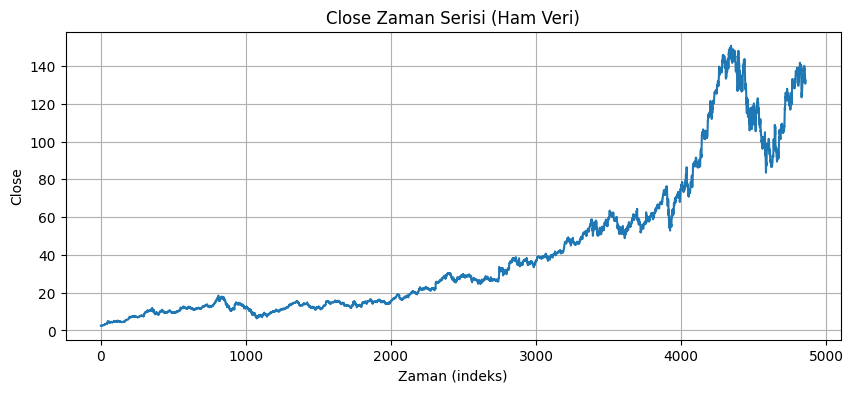

Şekil: (4858, 7)
Sütunlar: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Tarih sütunu: Date


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("GOOG.csv")

# detect date column
date_col = None
for c in df.columns:
    if c.lower() in ["date", "timestamp", "datetime"]:
        date_col = c
        break

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

# show head
print("GOOG.csv — İlk 10 Satır", df.head(10))

# pick y column for quick plot
ycol = "Close" if "Close" in df.columns else ("Adj Close" if "Adj Close" in df.columns else ("Open" if "Open" in df.columns else df.columns[1]))

plt.figure(figsize=(10,4))
plt.plot(df[ycol].values)
plt.title(f"{ycol} Zaman Serisi (Ham Veri)")
plt.xlabel("Zaman (indeks)")
plt.ylabel(ycol)
plt.grid(True)
plt.show()

print("Şekil:", df.shape)
print("Sütunlar:", df.columns.tolist())
print("Tarih sütunu:", date_col)


In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [18]:
#Open verilerini alıcaz sadece tahmin için
target_col = "Open"

In [19]:
#Verinin sıralı olduğuna dikkat edelim
df['Date'] = pd.to_datetime(df["Date"])
df = df.sort_values('Date').reset_index(drop=True)

In [20]:
values = df[[target_col]].values.astype(float) # sahape [N, 1]

In [21]:
# ---------- 2) Train/Test (zaman bilinçli) ----------
N = len(values)
test_ratio = 0.2
split = int(N * (1- test_ratio))
train_vals = values[:split]
test_vals = values[split:]

In [22]:
# ---------- 3) Ölçekleme (yalnızca train ile fit) ----------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
test_scaled  = scaler.transform(test_vals)

In [23]:
# Veriyi 60 gün -> sonraki 1 olarak ayarlıyoruz
LOOKBACK = 60
def make_windows(arr, lookback=60, horizon=1):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i,0])
        y.append(arr[i,0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1) # (örnekler, zaman, özellikler= 1)
    return X,y

X_train, y_train = make_windows(train_scaled, LOOKBACK, 1)
# For test, to emulate "rolling" windows without leakage, we need the last 60 points of train as context:
test_input = np.concatenate([train_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = make_windows(test_input, LOOKBACK, 1)


print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (3826, 60, 1) (3826,)
Test  shapes: (972, 60, 1) (972,)


In [24]:
# ---------- 5) Model ----------
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)
model = models.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[es, rl],
    verbose=1
)

Epoch 1/50
54/54 [==============================] - 10s 116ms/step - loss: 0.0069 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 5s 93ms/step - loss: 0.0015 - val_loss: 5.8597e-04 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 4s 79ms/step - loss: 0.0013 - val_loss: 0.0010 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 4s 73ms/step - loss: 0.0011 - val_loss: 6.0545e-04 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 4s 71ms/step - loss: 0.0012 - val_loss: 5.6674e-04 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 4s 71ms/step - loss: 0.0010 - val_loss: 8.8890e-04 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - ETA: 0s - loss: 0.0010    
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 [==============================] - 4s 79ms/step - loss: 0.0010 - val_loss: 5.8985e-04 - lr: 0.0010
Epoch 8/50
54/54 [==============================] 

In [25]:
# ---------- 6) Tahmin + ters ölçek ----------
y_pred_test_scaled = model.predict(X_test).reshape(-1,1)
y_pred_test = scaler.inverse_transform(y_pred_test_scaled).ravel()
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

31/31 [==============================] - 2s 22ms/step


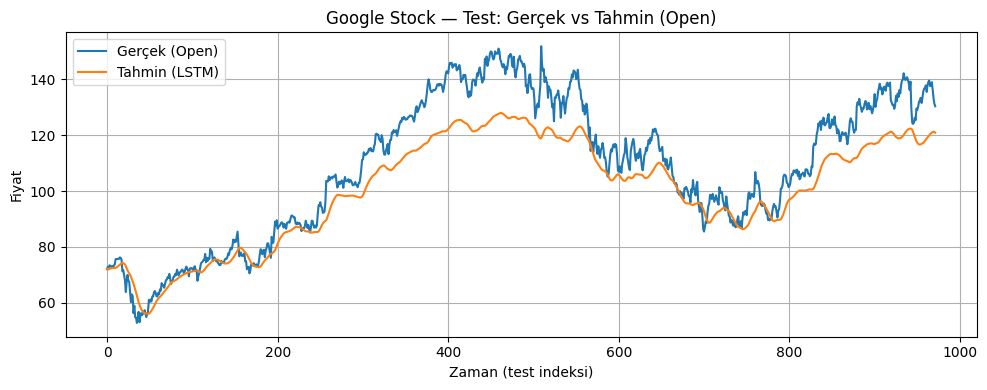

In [26]:
# ---------- 7) Grafik ----------
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label="Gerçek (Open)")
plt.plot(y_pred_test, label="Tahmin (LSTM)")
plt.title("Google Stock — Test: Gerçek vs Tahmin (Open)")
plt.xlabel("Zaman (test indeksi)")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# ---------- 8) Basit hata ölçümü ----------
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test_inv, y_pred_test)
mae = mean_absolute_error(y_test_inv, y_pred_test)
print(f"Test MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} | MAE: {mae:.4f}")

Test MSE: 121.6626 | RMSE: 11.0301 | MAE: 8.8874


harika sorular — hepsini netleştireyim.

# Neden bu iki callback?

### `EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)`

* **Ne yapar?** Doğrulama hatası (`val_loss`) **iyileşmeyi bırakınca** (üst üste 10 epoch boyunca daha iyi sonuç gelmezse) **eğitimi durdurur**.
* **Neden?** Aşırı öğrenmeyi (overfitting) ve **gereksiz epoch**ları önler; vakit & kaynak tasarrufu.
* **`restore_best_weights=True`**: Durdurduğunda **en iyi val\_loss**’ın olduğu epoch’taki **ağırlıkları geri yükler** (son epoch’ınkini değil).

### `ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)`

* **Ne yapar?** `val_loss` 5 epoch boyunca düzelmezse **öğrenme oranını yarıya düşürür** (`factor=0.5`).
* **Neden?** Büyük LR ile “sekme” yaşıyorsan, **daha küçük adımlarla** ince ayar yapabilsin.
* **`min_lr`** altına düşmez (çok yavaşlamasın diye).

> Log’da gördüğün “ReduceLROnPlateau reducing learning rate to …” satırları tam olarak bu mekanizma.
> En iyi `val_loss`’ınız **\~5.17e-04 (Epoch 26)** görünüyor. Ondan sonra 10 epoch daha iyileşme olmayınca **EarlyStopping** devreye girip **en iyi ağı** geri yükledi.

---

# Neden inverse transform yapıyoruz?

```python
y_pred_test = scaler.inverse_transform(y_pred_test_scaled).ravel()
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
```

* Eğitimde kullandığımız **MinMaxScaler** değerleri **0–1** aralığına taşır.
* Tahminler de 0–1’dedir.
* **Grafik çizmek** (gerçek fiyatlarla kıyaslamak) ve **hata metriklerini anlamlı birimlerde** (≈ USD) hesaplamak için **orijinal ölçeğe geri döndürürüz** (`inverse_transform`).
* Aksi halde MSE/MAE “normalize” ölçekte olur, “kaç dolar” hata yaptığını söylemez.

---

# Eğitim log’unu nasıl okuyalım?

* Başta `lr=0.001` ile hızlı iniyorsun; iyileşme durunca **LR yarıya** düşüyor (Epoch 7, 12, 17, 22, 27, 32…).
* **En iyi val\_loss** Epoch **26**: `5.1732e-04`. Sonrasında iniş gelmeyince 10 epoch bekleyip **EarlyStopping** durmuş.
* Bu iyi bir işaret: **aşırı uzun** eğitmemişsin ve **en iyi ağı** kullanıyorsun.

---

# Test sonuçlarını yorum

```
Test MSE: 121.6626 | RMSE: 11.0301 | MAE: 8.8874
```

* Bunlar **orijinal ölçek** (USD).
* Yani test döneminde ortalama **\~\$8.9 mutlak hata**, **\~\$11 RMSE**.
* Göreli görmek istersen **MAPE** (yüzde hata) bak: küçük bir yardımcı hesapla genelde daha anlamlı olur (örn. %1–2 bandı iyidir).

---

# Küçük pratik öneriler (istersen dene)

1. **MAPE ekle**

   ```python
   mape = np.mean(np.abs((y_test_inv - y_pred_test) / y_test_inv)) * 100
   print(f"MAPE: {mape:.2f}%")
   ```

2. **Çok değişkenli giriş** deneyin (çoğu zaman daha iyi):

   * Girdi özellikleri: `Open, High, Low, Close, Volume`
   * Sadece hedefi (`Open`) inverse yaparsın.

3. **Pencere uzunluğu** (LOOKBACK) ve **hidden size**’ı tarayın:

   * LOOKBACK: 30 / 60 / 90
   * LSTM ünite: 32 / 64 / 128
   * En iyi kombinasyonu **val\_loss**’a göre seç.

4. **Horizon>1** (çok adım ileri) gerekiyorsa:

   * `Dense(HORIZON)` + `y`’yi `(n, HORIZON)` hazırlayın.

5. **Özellik mühendisliği**:

   * Fark veya getiri: `r_t = (Close_t / Close_{t-1}) - 1`
   * Log-volume, hareketli ortalamalar, volatilite gibi teknik göstergeler (aşırıya kaçmadan).

---

## Özet

* **EarlyStopping**: iyileşme durunca **erken bitir** + **en iyi ağı** yükle.
* **ReduceLROnPlateau**: iyileşme durunca **LR’ı düşür**, daha hassas öğren.
* **inverse\_transform**: **grafik ve metrikleri** **gerçek birimde** (USD) hesaplamak için şart.
* Log’lar **sağlıklı** görünüyor; en iyi epoch’ta ağ geri yüklendi.
* Hatanı daha da düşürmek için **multivariate giriş**, **LOOKBACK/units** taraması ve **MAPE** ile izleme iyi adımlar olur.

İstersen bir sonraki mesajda, aynı veriyle **çok değişkenli (5 feature) LSTM**’in mini kodunu da bırakayım; sadece birkaç satır fark var.
